# ML_np20ng_30K

- Machine Learning Algorithms - MNB, RF, and SVM
- np20ng - Nepali newsgroup dataset with 20 classes
- dataset size - 30K (1500 rows per class)

In [1]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

### Import required libraries

In [2]:
import pandas as pd
import os
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold

### Load Data

- Specify constants and dataset paths.
- Load data from path

We are loading *preprocessed* dataset with *stopwords removed by stemming*.

In [3]:
size = '30K'
dataset = 'np20ng'
datapath = os.path.join('/home/suyogyat/research/dataset', size)
modelspath = os.path.join(os.getcwd(), 'models')

train_path = os.path.join(datapath, f'{dataset}_{size}_train_nosw.csv')
valid_path = os.path.join(datapath, f'{dataset}_{size}_valid_nosw.csv')
test_path = os.path.join(datapath, f'{dataset}_{size}_test_nosw.csv')

columns = ['content', 'category', 'labels']
train_df = pd.read_csv(train_path)[columns]
valid_df = pd.read_csv(valid_path)[columns]
test_df = pd.read_csv(test_path)[columns]

### Feature Extraction using TF-IDF Vectorizer

We use this configuration of TF-IDF Vectorizer to vectorize the text data i.e. `content` column in the datasets

- `ngram_range=(1, 4)`
- `max_features=2000`
- As Nepali does not have capitalization, `lowercase=False`
- `tokenizer` tokenizes the text on whitespaces.

In [4]:
# TF-IDF configuration
ngram_range = (1, 4)
min_df = 10
max_df = 0.5
max_features = 2000

# Initialize TF-IDF Vectorizer, 
tfidf = TfidfVectorizer(encoding='utf-8', 
                        ngram_range=ngram_range, 
                        max_df=max_df, 
                        min_df=min_df, 
                        max_features=max_features, 
                        norm='l2', 
                        sublinear_tf=True,
                        lowercase=False, 
                        tokenizer=lambda x: x.split(' '))

In [5]:
X_train, X_valid, X_test = train_df.content, valid_df.content, test_df.content
y_train, y_valid, y_test = train_df.labels, valid_df.labels, test_df.labels
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((24000,), (24000,), (3000,), (3000,), (3000,), (3000,))

In [6]:
%time 
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

features_valid = tfidf.transform(X_valid).toarray()
labels_valid = y_valid

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

features_train.shape, features_valid.shape, features_test.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


((24000, 2000), (3000, 2000), (3000, 2000))

`tfidf.fit_transform` learns the vocabulary dictionary and returns a Document-Term matrix (no. of samples, no. of features)

### Helpers for Confusion matrix

We also have column named `labels` for categorical column named `category`.

A mapping is done for these values to retain one value from the other.

In [7]:
# Mapping numerical labels into categorical values
categories = train_df.category.unique()
labels = train_df.labels.unique()

label2id = {}
for category, label in zip(categories, labels):
    label2id[category] = label
id2label = {v: k for k, v in label2id.items()}

In [8]:
def create_confusion_matrix(y_true, y_pred, title):
    """Generates a confusion matrix.

    Parameters
    ----------
    y_true : list
        List of true test values.
    y_pred : list
        List of predicted values.
    title : str
        Title of the confusion matrix.
    """
    data = {'y_true': y_true, 'y_pred': y_pred}
    df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

    df.y_true = df.y_true.map(id2label)
    df.y_pred = df.y_pred.map(id2label)
    
    confusion_matrix = pd.crosstab(df['y_true'], df['y_pred'], rownames=['Actual Category'], colnames=['Predicted Category'])
    
    fig = plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g').set_title(title)

## Using Nested CV for MNB, RF and SVM (data = 30K)

We use Grid Search using Nested Cross Validation with **5 folds in outer loop**, and **3 folds in inner loop**.

In [9]:
start_time = time.time()

OUTER_FOLDS = 5
INNER_FOLDS = 3

# Initializing Classifiers
clf_mnb = MultinomialNB()
clf_rf = RandomForestClassifier()
clf_svm = SVC()

# Setting up the parameter grids
param_grid_mnb = {
    'alpha': [1, 0.1, 0.01, 0.001],
}

param_grid_rf = {
    'max_depth': [70, 100, 200, 300],
    'n_estimators': [100, 500, 800, 1000]
}

param_grid_svm = [{
    'kernel': ['rbf'],
    'C': [ 10, 50, 100],
    'gamma': [1, 0.1, 0.01]
}, {
    'kernel': ['linear'], 
    'C': [10, 50, 100]
}]

# Setting up GridSearchCV objects
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=44)

for pgrid, clf, name in zip((param_grid_mnb, param_grid_rf, param_grid_svm),
                           (clf_mnb, clf_rf, clf_svm),
                           ('MultinomialNaiveBayes', 'RandomForest', 'SVM')):
    gcv = GridSearchCV(estimator=clf, 
                       param_grid=pgrid, 
                       scoring='accuracy', 
                       n_jobs=-1, 
                       cv=inner_cv, 
                       verbose=0, 
                       refit=True)
    
    gridcvs[name] = gcv
    

for name, gs_est in sorted(gridcvs.items()):
    print(50 * '-', '\n')
    print('Algorithm: ', name)
    
    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=44)
    
    for train_idx, valid_idx in outer_cv.split(features_train, labels_train):
        
        print('\n  Outer Loop: ', len(outer_scores) + 1)
        gridcvs[name].fit(features_train[train_idx], labels_train[train_idx])
        print('        Best ACC (best of inner test folds) %.2f%%' % (gridcvs[name].best_score_ * 100))
        print('        Best parameters:', gridcvs[name].best_params_)
        print('        Best estimator:', gridcvs[name].best_estimator_)
        print('        Best estimator score (train_set):', gridcvs[name].best_estimator_.score(features_train[train_idx], labels_train[train_idx]))
        print('        Refit time:', gridcvs[name].refit_time_)
        
        outer_scores.append(gridcvs[name].best_estimator_.score(features_train[valid_idx], labels_train[valid_idx]))
        print('        ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
        
    print('\n    Outer Loop:')
    print('        ACC %.2f%% +/- %.2f' % (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))
    
total_time = time.time() - start_time
print(f'\nTotal Execution time: {np.round(total_time, 3)} seconds')

-------------------------------------------------- 

Algorithm:  MultinomialNaiveBayes

  Outer Loop:  1
        Best ACC (best of inner test folds) 73.16%
        Best parameters: {'alpha': 0.01}
        Best estimator: MultinomialNB(alpha=0.01)
        Best estimator score (train_set): 0.7666145833333333
        Refit time: 0.08023500442504883
        ACC (on outer test fold) 73.19%

  Outer Loop:  2
        Best ACC (best of inner test folds) 73.48%
        Best parameters: {'alpha': 0.1}
        Best estimator: MultinomialNB(alpha=0.1)
        Best estimator score (train_set): 0.7619270833333334
        Refit time: 0.06593012809753418
        ACC (on outer test fold) 73.48%

  Outer Loop:  3
        Best ACC (best of inner test folds) 73.39%
        Best parameters: {'alpha': 0.01}
        Best estimator: MultinomialNB(alpha=0.01)
        Best estimator score (train_set): 0.7667708333333333
        Refit time: 0.06648612022399902
        ACC (on outer test fold) 73.44%

  Outer Loo

/home/suyogyat/research/nlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


        Best ACC (best of inner test folds) 75.94%
        Best parameters: {'max_depth': 300, 'n_estimators': 800}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=800)
        Best estimator score (train_set): 1.0
        Refit time: 153.2957525253296
        ACC (on outer test fold) 76.52%

  Outer Loop:  2


/home/suyogyat/research/nlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


        Best ACC (best of inner test folds) 76.19%
        Best parameters: {'max_depth': 300, 'n_estimators': 800}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=800)
        Best estimator score (train_set): 1.0
        Refit time: 153.62994122505188
        ACC (on outer test fold) 75.71%

  Outer Loop:  3


/home/suyogyat/research/nlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


        Best ACC (best of inner test folds) 75.99%
        Best parameters: {'max_depth': 300, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=1000)
        Best estimator score (train_set): 1.0
        Refit time: 223.12958097457886
        ACC (on outer test fold) 76.88%

  Outer Loop:  4


/home/suyogyat/research/nlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


        Best ACC (best of inner test folds) 76.10%
        Best parameters: {'max_depth': 200, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=200, n_estimators=1000)
        Best estimator score (train_set): 1.0
        Refit time: 227.51411318778992
        ACC (on outer test fold) 76.54%

  Outer Loop:  5


/home/suyogyat/research/nlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


        Best ACC (best of inner test folds) 75.83%
        Best parameters: {'max_depth': 300, 'n_estimators': 1000}
        Best estimator: RandomForestClassifier(max_depth=300, n_estimators=1000)
        Best estimator score (train_set): 1.0
        Refit time: 206.5338819026947
        ACC (on outer test fold) 77.29%

    Outer Loop:
        ACC 76.59% +/- 0.52
-------------------------------------------------- 

Algorithm:  SVM

  Outer Loop:  1
        Best ACC (best of inner test folds) 79.98%
        Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
        Best estimator: SVC(C=10, gamma=1)
        Best estimator score (train_set): 0.9999479166666667
        Refit time: 229.12349343299866
        ACC (on outer test fold) 80.71%

  Outer Loop:  2
        Best ACC (best of inner test folds) 79.80%
        Best parameters: {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
        Best estimator: SVC(C=50, gamma=1)
        Best estimator score (train_set): 1.0
        Refit time: 234.98

### Multinomial Naive Bayes

We find that the average accuracy is achieved by the outer loop of nested CV is 73.34% and the optimal hyperparameters are `alpha=0.01`.

We fit this parameters on MNB and report the accuracies on Validation set and Test set.

Validation Accuracy:  0.7203333333333334
               precision    recall  f1-score   support

         Arts       0.68      0.62      0.65       150
   Automobile       0.79      0.85      0.82       150
         Bank       0.65      0.69      0.67       150
     Business       0.45      0.36      0.40       150
        Crime       0.80      0.92      0.85       150
      Economy       0.48      0.41      0.44       150
    Education       0.77      0.91      0.83       150
   Employment       0.82      0.77      0.79       150
Entertainment       0.80      0.77      0.78       150
       Health       0.64      0.46      0.54       150
    Lifestyle       0.66      0.83      0.74       150
   Literature       0.71      0.79      0.74       150
       Market       0.67      0.57      0.62       150
      Opinion       0.80      0.87      0.84       150
     Politics       0.78      0.83      0.81       150
      Society       0.67      0.55      0.60       150
       Sports       0.9

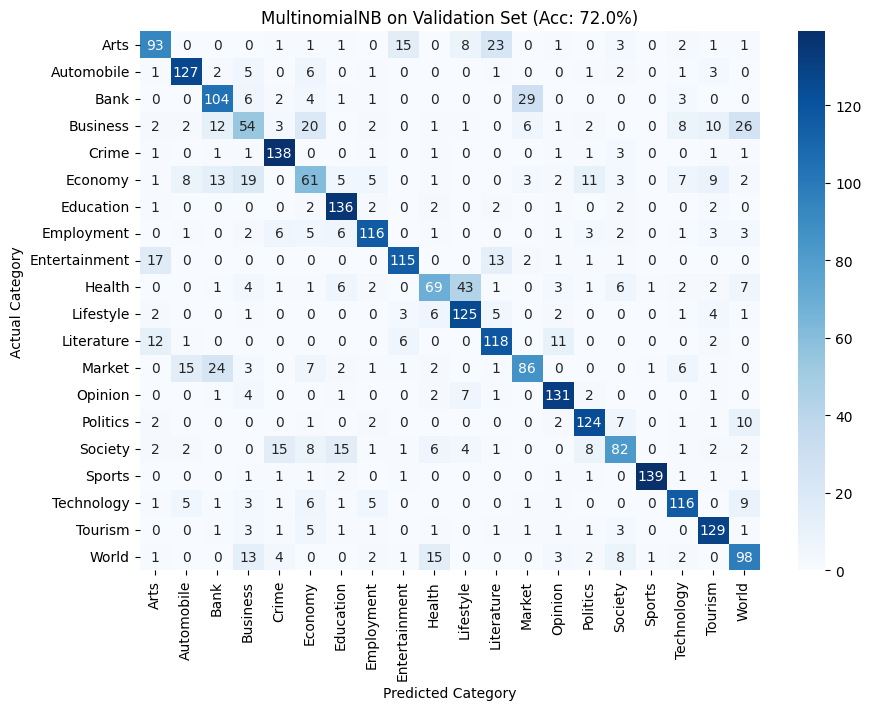

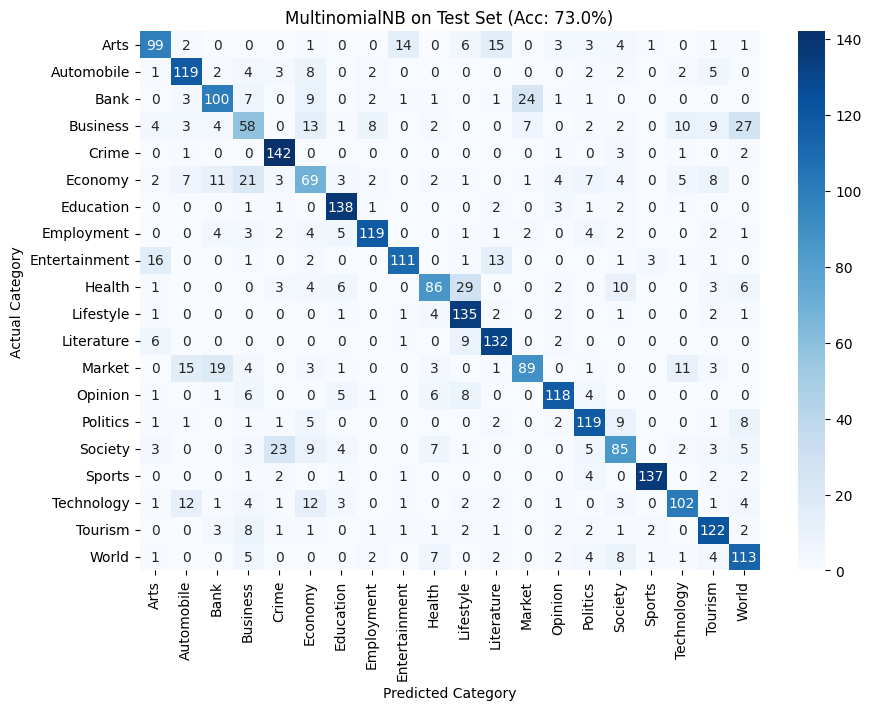

In [10]:
mnb_model = MultinomialNB(alpha=0.01)
mnb_model.fit(features_train, labels_train)

model_predictions_valid = mnb_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'MultinomialNB on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = mnb_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'MultinomialNB on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')

### Random Forest

We find that the average accuracy is achieved by the outer loop of nested CV is 76.59% and the optimal hyperparameters are `max_depth=0.01` and `n_estimators=1000`.

We fit this parameters on RF classifier and report the accuracies on Validation set and Test set.

Validation Accuracy:  0.759
               precision    recall  f1-score   support

         Arts       0.73      0.76      0.75       150
   Automobile       0.82      0.85      0.84       150
         Bank       0.79      0.85      0.82       150
     Business       0.66      0.30      0.41       150
        Crime       0.84      0.91      0.87       150
      Economy       0.57      0.46      0.51       150
    Education       0.80      0.94      0.86       150
   Employment       0.84      0.76      0.80       150
Entertainment       0.82      0.77      0.79       150
       Health       0.66      0.58      0.62       150
    Lifestyle       0.69      0.81      0.74       150
   Literature       0.83      0.73      0.78       150
       Market       0.79      0.75      0.77       150
      Opinion       0.83      0.90      0.86       150
     Politics       0.79      0.87      0.83       150
      Society       0.59      0.75      0.66       150
       Sports       0.91      0.96  

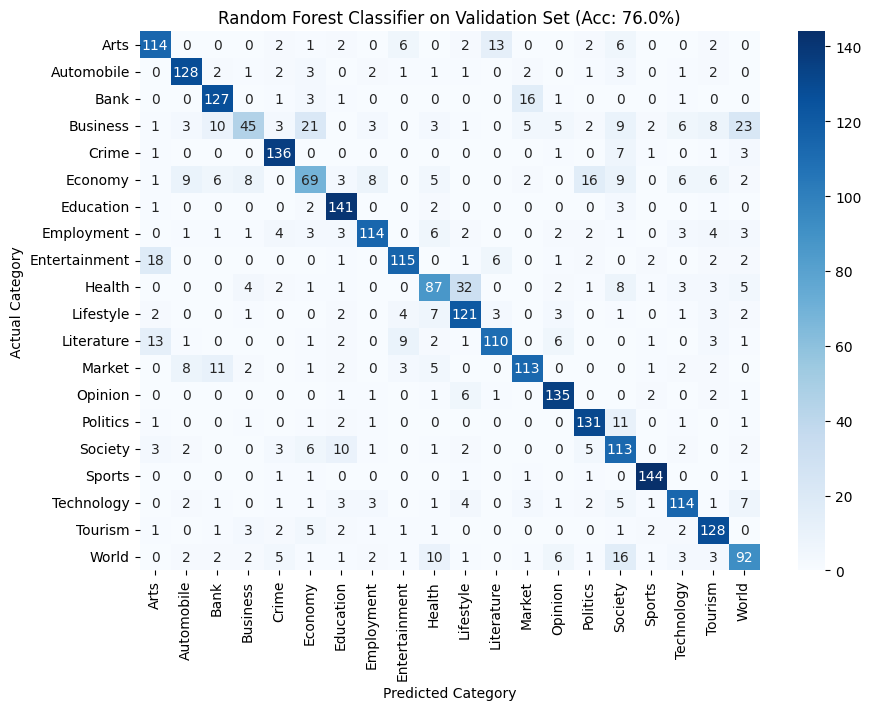

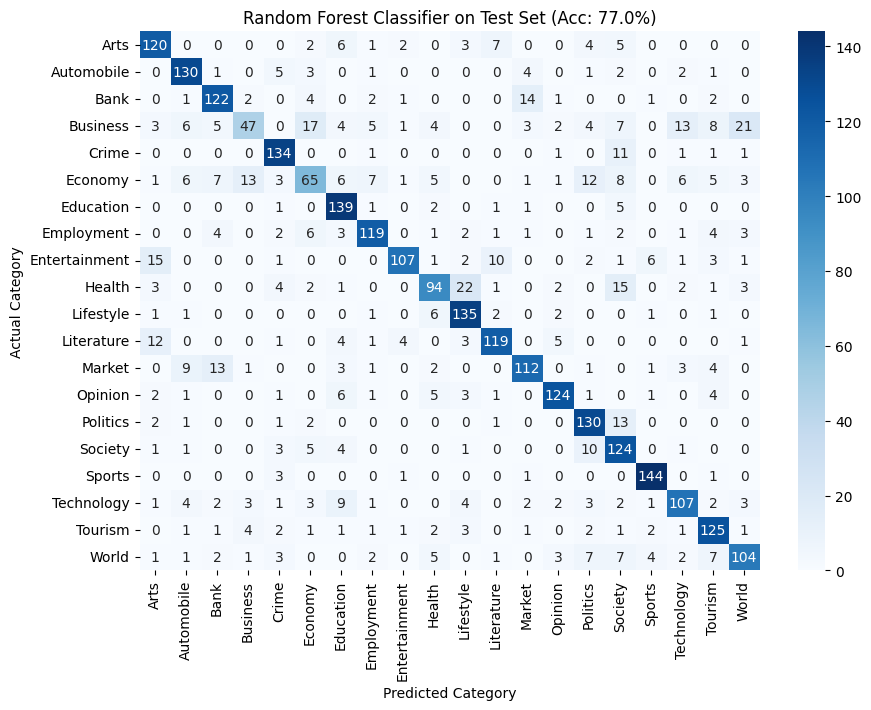

In [11]:
rf_model = RandomForestClassifier(max_depth=300, n_estimators=1000)

rf_model.fit(features_train, labels_train)

model_predictions_valid = rf_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'Random Forest Classifier on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = rf_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'Random Forest Classifier on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')

### SVM

We find that the average accuracy is achieved by the outer loop of nested CV is 80.51% and the optimal hyperparameters are `C=50` and `gamma=1`.

We fit this parameters on SVM classifier and report the accuracies on Validation set and Test set.

Validation Accuracy:  0.8013333333333333
               precision    recall  f1-score   support

         Arts       0.76      0.79      0.78       150
   Automobile       0.88      0.88      0.88       150
         Bank       0.82      0.79      0.81       150
     Business       0.55      0.52      0.53       150
        Crime       0.90      0.89      0.90       150
      Economy       0.64      0.55      0.59       150
    Education       0.89      0.92      0.90       150
   Employment       0.82      0.84      0.83       150
Entertainment       0.82      0.81      0.82       150
       Health       0.72      0.70      0.71       150
    Lifestyle       0.81      0.84      0.82       150
   Literature       0.84      0.81      0.82       150
       Market       0.80      0.79      0.80       150
      Opinion       0.90      0.92      0.91       150
     Politics       0.86      0.83      0.85       150
      Society       0.65      0.72      0.69       150
       Sports       0.9

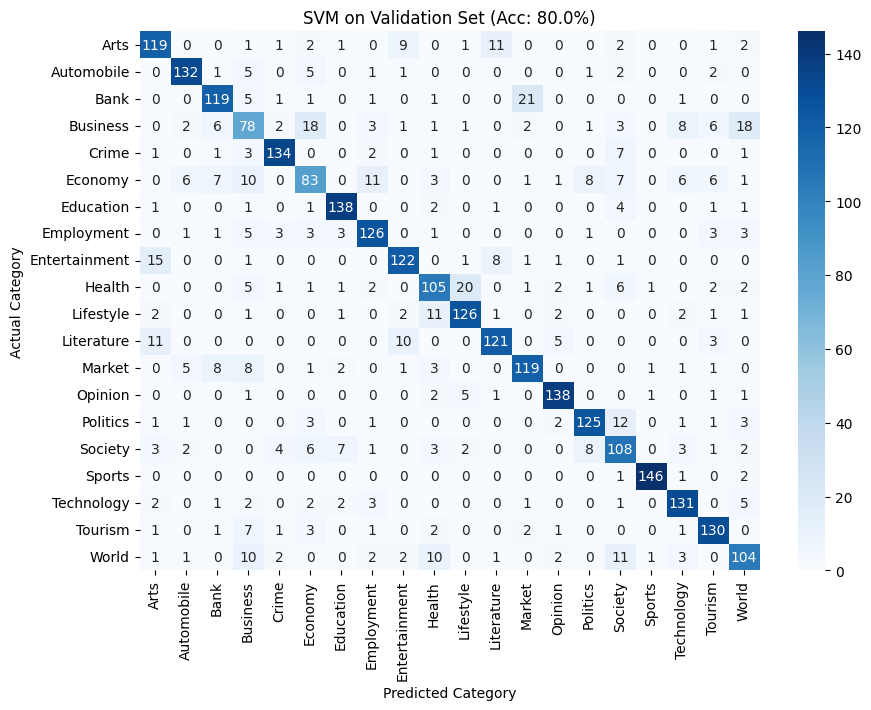

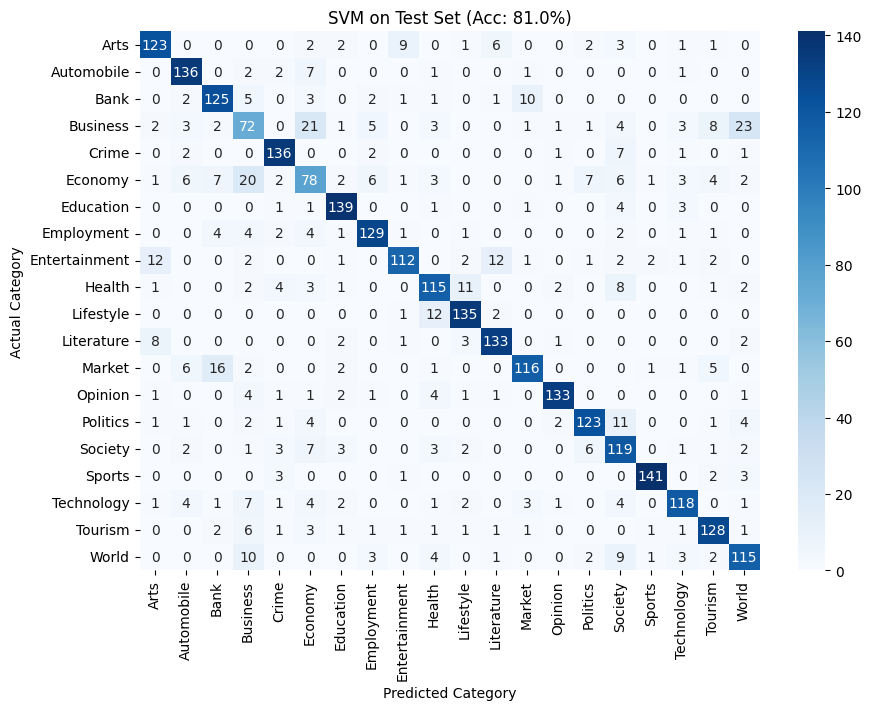

In [13]:
svm_model = SVC(C=50, gamma=1)
svm_model.fit(features_train, labels_train)

model_predictions_valid = svm_model.predict(features_valid)
print('Validation Accuracy: ', accuracy_score(labels_valid, model_predictions_valid))
print(classification_report(labels_valid, model_predictions_valid, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_valid, model_predictions_valid, f'SVM on Validation Set (Acc: {round(accuracy_score(labels_valid, model_predictions_valid), 2) * 100}%)')

model_predictions_test = svm_model.predict(features_test)
print('Test Accuracy: ', accuracy_score(labels_test, model_predictions_test))
print(classification_report(labels_test, model_predictions_test, target_names=np.sort(list(label2id.keys()))))
create_confusion_matrix(labels_test, model_predictions_test, f'SVM on Test Set (Acc: {round(accuracy_score(labels_test, model_predictions_test), 2) * 100 }%)')

## Conclusion

SVM achieved the highest test accuracy followed by Random Forest and Multinomial Naive Bayes of larger variation of dataset (30K rows).

### Credits:

Nepali Stemmer: [Oyesh Mann Singh](https://pypi.org/project/nepali-stemmer/)

Nested cross validation procedure: [Sebastian Raschka](https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L11/code/11-eval4-algo__nested-cv_verbose1.ipynb)